# Notebook of comparison VAE and geometric VAE

In [24]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

from scCFM.models.base.vae import VAE
from scCFM.models.base.geometric_vae import GeometricNBVAE
from scCFM.models.base.geodesic_ae import GeodesicAE
from scCFM.datamodules.sc_datamodule import scDataModule

from scCFM.models.manifold.geometry_metrics import compute_all_metrics

import sys
sys.path.insert(0, "../..")
from notebooks.utils import real_reconstructed_cells_adata

from paths import PROJECT_FOLDER
import anndata
import torch

## Initialize the two different configurations 

In [15]:
terminal_states = [4, 1, 5, 6] 
initial_states = [2]

General module hparams

In [2]:
datamodule={'path': PROJECT_FOLDER / 'data' / 'schiebinger_et_al' / 'processed' / 'schiebinger_et_al.h5ad', 
            'x_layer': 'X_norm', 
            'cond_keys': ['experimental_time', 'cell_sets'],
            'use_pca': False, 
            'n_dimensions': None, 
            'train_val_test_split': [1], 
            'batch_size': 256, 
            'num_workers': 2}

# Initialize datamodule
datamodule = scDataModule(**datamodule)

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


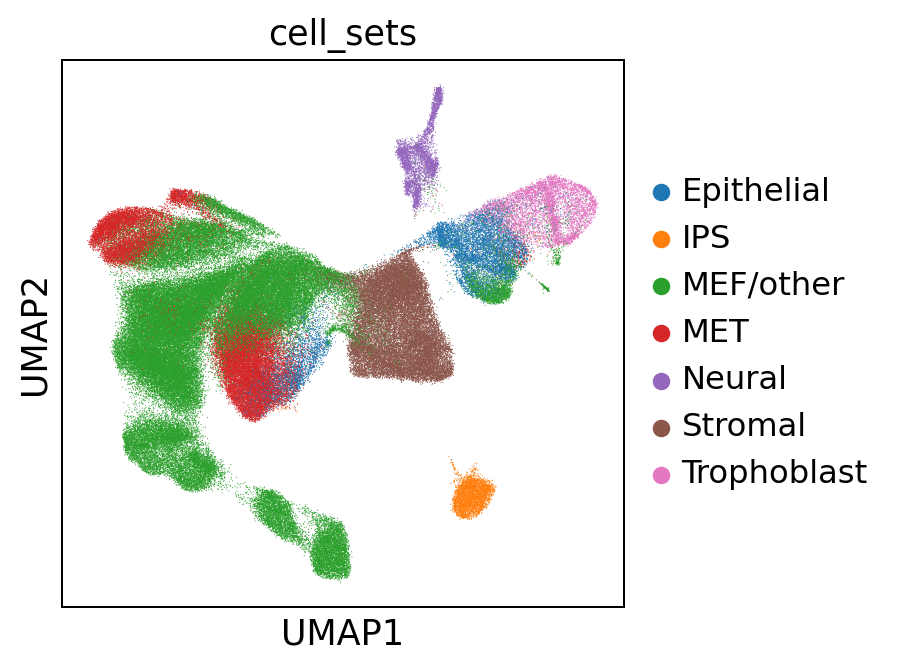

In [14]:
adata = sc.read_h5ad(PROJECT_FOLDER / 'data' / 'schiebinger_et_al' / 'processed' / 'schiebinger_et_al.h5ad')
sc.pl.umap(adata, color="cell_sets")

### Model config VAE

In [3]:
model_vae={
       'in_dim': datamodule.in_dim,
       'n_epochs_anneal_kl': 1000, 
       'kl_weight': None, 
       'likelihood': 'nb', 
       'dropout': False, 
       'learning_rate': 0.001, 
       'dropout_p': False, 
       'model_library_size': True, 
       'batch_norm': True, 
       'kl_warmup_fraction': 0.1, 
       'hidden_dims': [256, 10]}
        
geometric={'compute_metrics_every': 1, 
           'use_c': True, 
           'l2': True, 
           'eta_interp': 0, 
           'interpolate_z': False, 
           'start_jac_after': 0, 
           'fl_weight': 0.1,
           'detach_theta': True}

geodesic={"in_dim": datamodule.in_dim,
          "hidden_dims": [256, 10],
          "batch_norm": True,
          "dropout": False, 
          "dropout_p": False,
          "likelihood": "nb",
          "learning_rate": 0.001}

In [4]:
vae = GeometricNBVAE(**geometric, vae_kwargs=model_vae)
geometric_vae = GeometricNBVAE(**geometric, vae_kwargs=model_vae)
geodesic_ae = GeodesicAE(**geodesic).eval()

In [5]:
vae.load_state_dict(torch.load(PROJECT_FOLDER / "checkpoints/ae/schiebinger_et_al/best_model_vae.ckpt")["state_dict"])
geometric_vae.load_state_dict(torch.load(PROJECT_FOLDER / "checkpoints/ae/schiebinger_et_al/best_model_geometric.ckpt")["state_dict"])
geodesic_ae.load_state_dict(torch.load(PROJECT_FOLDER / "checkpoints/ae/schiebinger_et_al/best_model_geodesic.ckpt")["state_dict"])

<All keys matched successfully>

In [6]:
datamodule.cond_keys

['experimental_time', 'cell_sets']

### Compute UMAPs

In [7]:
adata_vae_z = real_reconstructed_cells_adata(vae, datamodule, process_amortized_adata=False, compute_umap=False, log1p=False, vae=True)
adata_geometric_z = real_reconstructed_cells_adata(geometric_vae, datamodule, process_amortized_adata=False, compute_umap=False, log1p=False, vae=True)
adata_geodesic_z = real_reconstructed_cells_adata(geodesic_ae, datamodule, process_amortized_adata=False, log1p=False, vae=False, model_type="geodesic")

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [8]:
adata_vae_z

AnnData object with n_obs × n_vars = 165888 × 10
    obs: 'experimental_time', 'cell_sets', 'log_library_size'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

Plot the UMAP results

In [9]:
adata_vae_z.obs["cell_sets"] = adata_vae_z.obs["cell_sets"].astype("category")
adata_geometric_z.obs["cell_sets"] = adata_geometric_z.obs["cell_sets"].astype("category")
adata_geodesic_z.obs["cell_sets"] = adata_geodesic_z.obs["cell_sets"].astype("category")

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


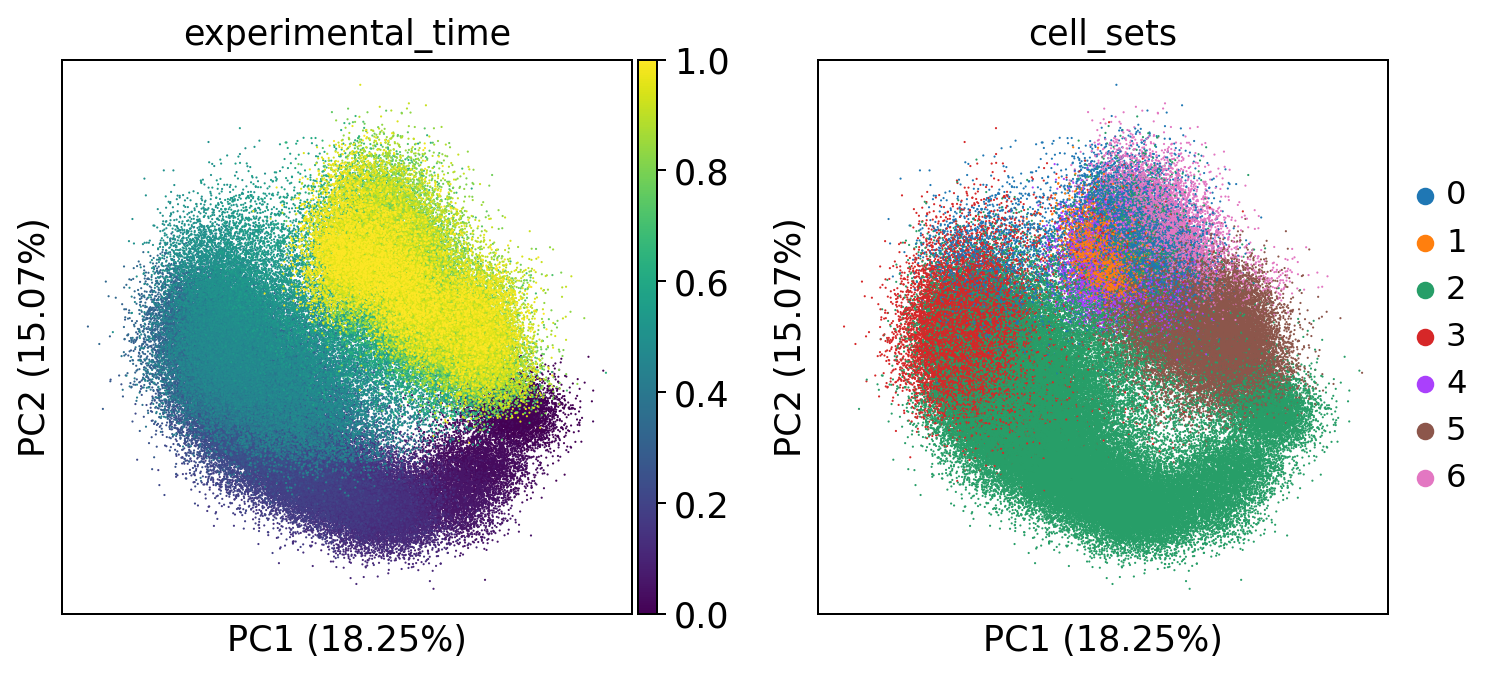

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


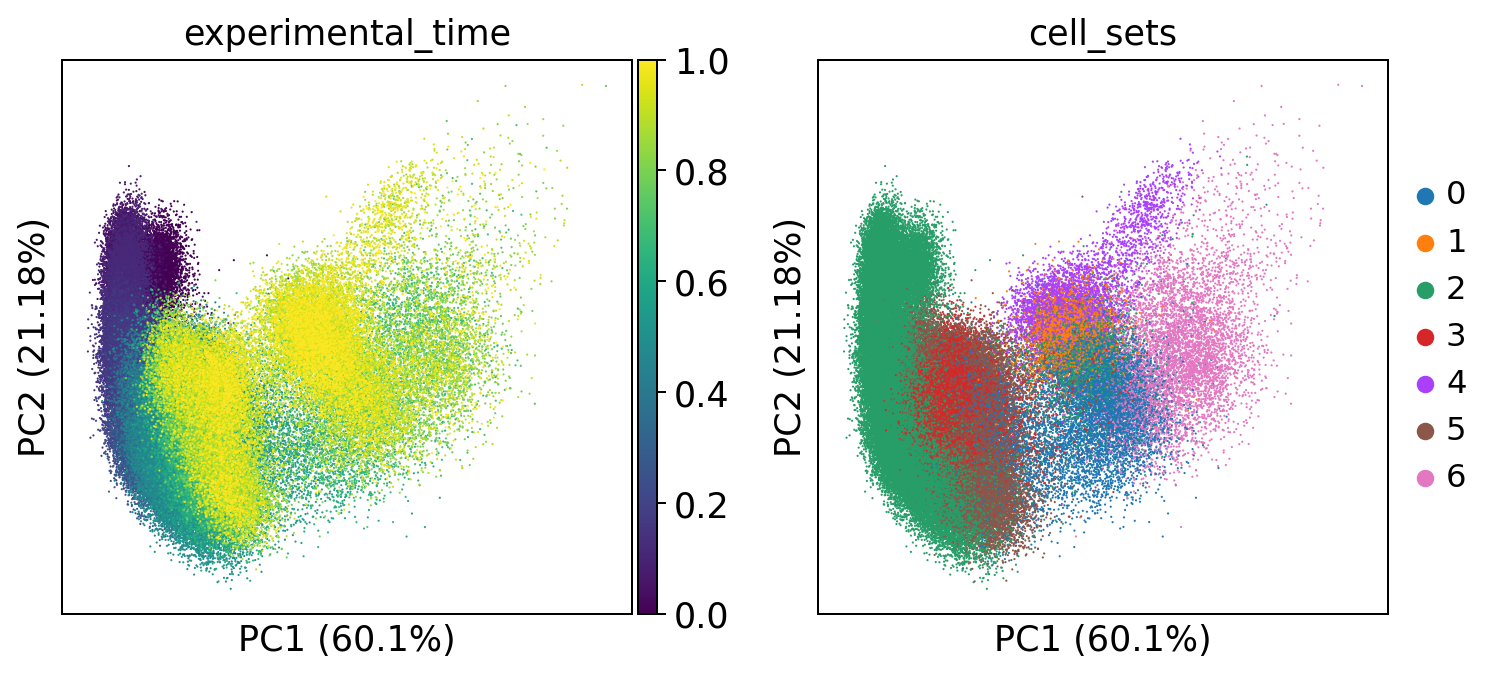

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


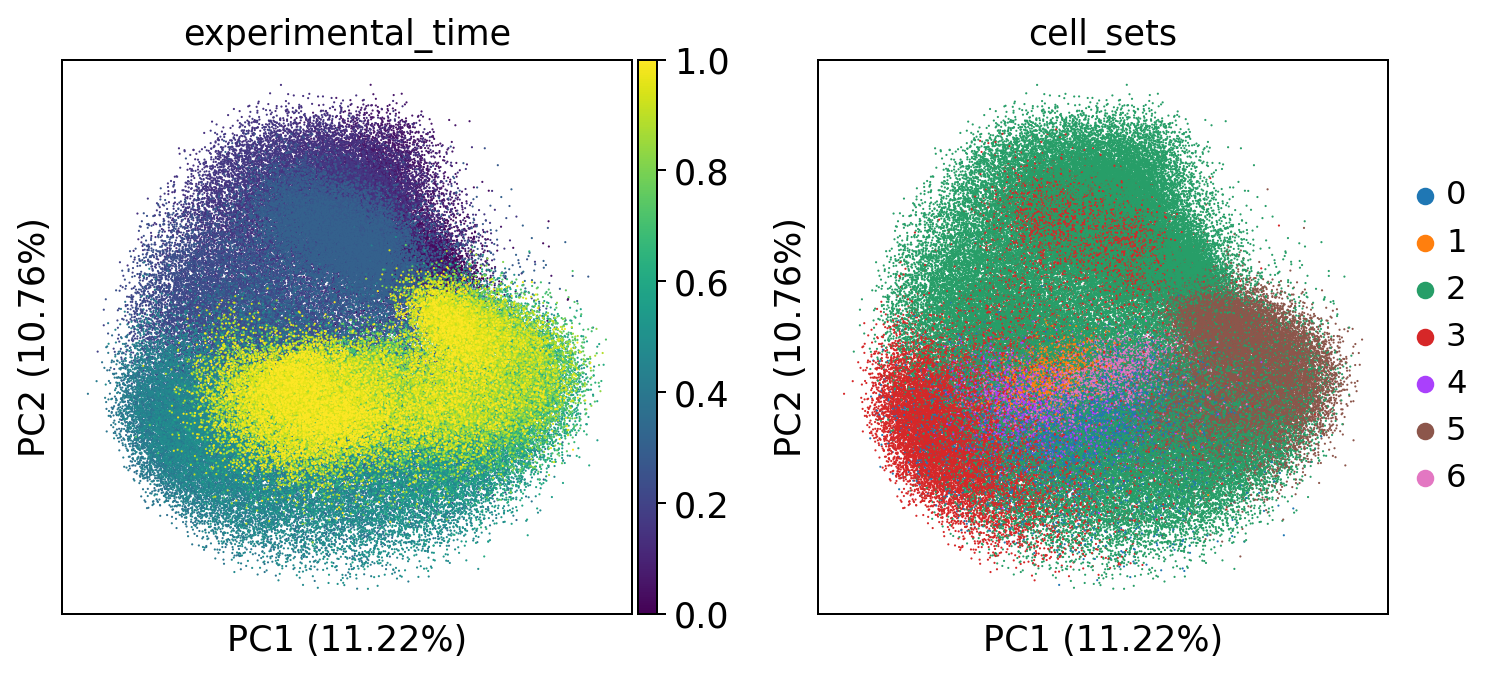

In [10]:
sc.set_figure_params(scanpy=True,
                         dpi=90, 
                         dpi_save=150,
                         frameon=True, 
                         vector_friendly=True,
                         fontsize=14, 
                         figsize=None,
                         color_map=None, 
                         format='pdf', 
                         facecolor=None, 
                         transparent=False, 
                         ipython_format='png2x')

sc.pl.pca(adata_vae_z, color=["experimental_time", "cell_sets"], size=3,add_outline=False, annotate_var_explained=True)
sc.pl.pca(adata_geometric_z, color=["experimental_time", "cell_sets"], size=3, add_outline=False, annotate_var_explained=True)
sc.pl.pca(adata_geodesic_z, color=["experimental_time", "cell_sets"], size=3, add_outline=False, annotate_var_explained=True)

## Plots for figure

In [21]:
geometric_state_type = []
vae_state_type = []
geodesic_state_type = []

for clus in adata_geometric_z.obs.cell_sets:
    if clus in terminal_states:
       geometric_state_type.append("terminal states") 
    elif clus in initial_states:
       geometric_state_type.append("initial state") 
    else:
       geometric_state_type.append("intermediate states") 

for clus in adata_vae_z.obs.cell_sets:
    if clus in terminal_states:
       vae_state_type.append("terminal states") 
    elif clus in initial_states:
       vae_state_type.append("initial state") 
    else:
       vae_state_type.append("intermediate states") 

for clus in adata_geodesic_z.obs.cell_sets:
    if clus in terminal_states:
       geodesic_state_type.append("terminal states") 
    elif clus in initial_states:
       geodesic_state_type.append("initial state") 
    else:
       geodesic_state_type.append("intermediate states") 

adata_geometric_z.obs["state_type"] = geometric_state_type
adata_geodesic_z.obs["state_type"] = geodesic_state_type
adata_vae_z.obs["state_type"] = vae_state_type

adata_vae_z.uns['state_type_colors'] = ["firebrick", "gainsboro", "dodgerblue"]
adata_geometric_z.uns['state_type_colors'] = ["firebrick", "gainsboro", "dodgerblue"]
adata_geodesic_z.uns['state_type_colors'] = ["firebrick", "gainsboro", "dodgerblue"]

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


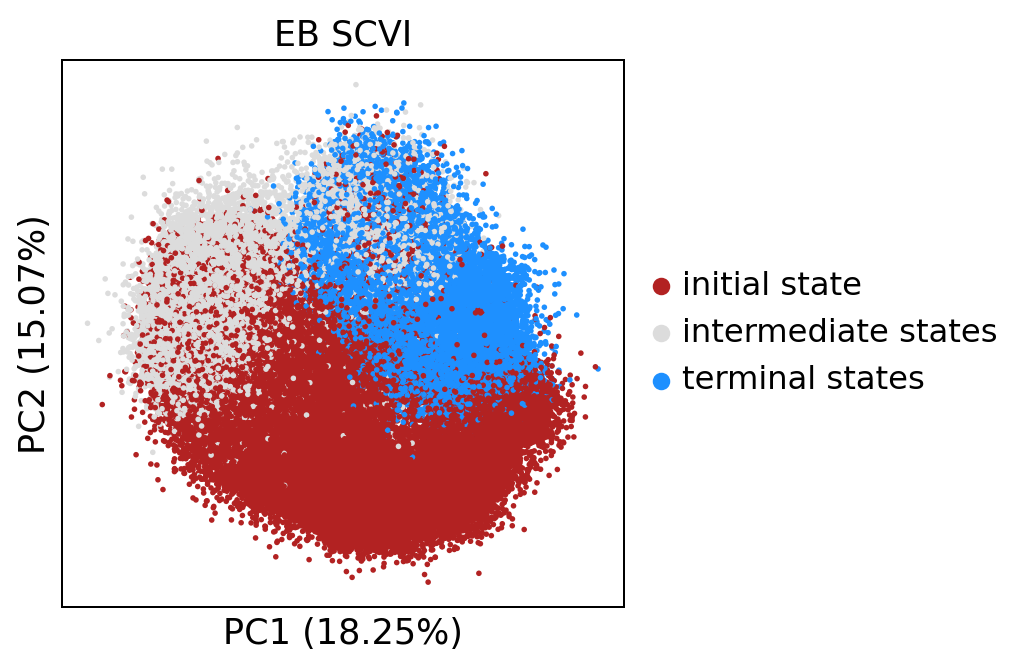

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


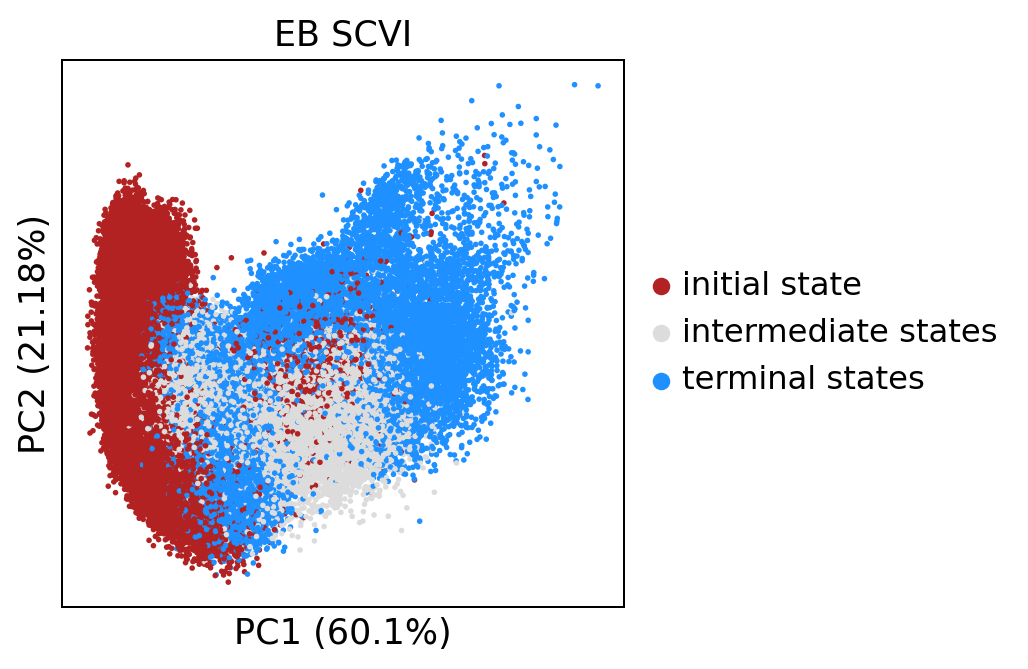

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


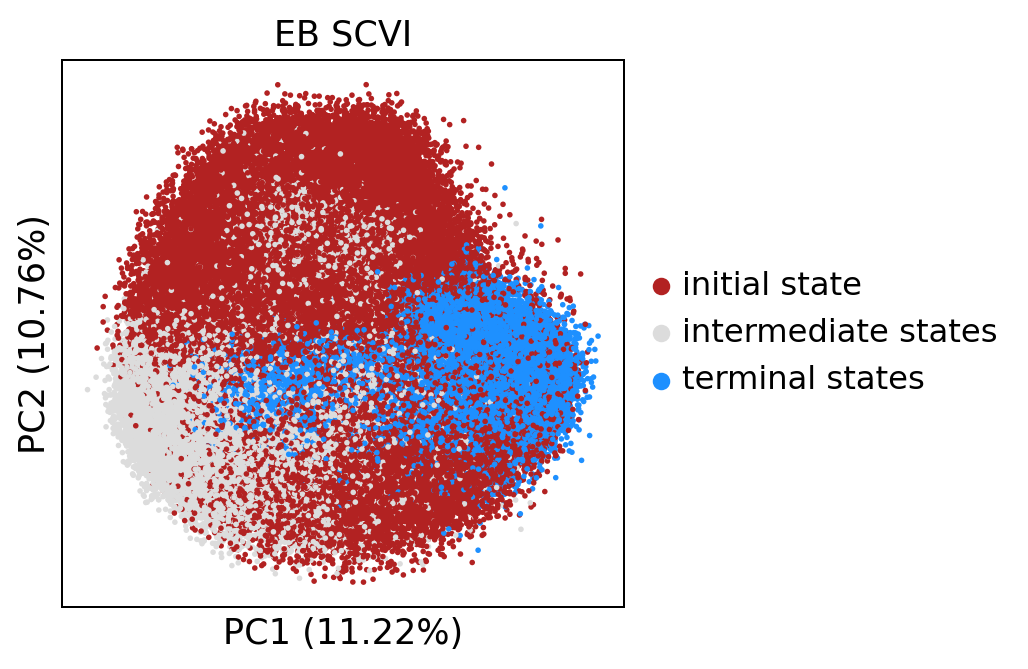

In [26]:
sc.set_figure_params(scanpy=True,
                         dpi=90, 
                         dpi_save=150,
                         frameon=False, 
                         vector_friendly=True,
                         fontsize=14, 
                         figsize=None,
                         color_map=None, 
                         format='pdf', 
                         facecolor=None, 
                         transparent=False, 
                         ipython_format='png2x')

sc.pl.pca(adata_vae_z, color="state_type", 
          annotate_var_explained=True,
          frameon=True,
          add_outline=False, 
          size=20, 
         title="EB SCVI")

sc.pl.pca(adata_geometric_z, color="state_type", 
          annotate_var_explained=True,
          frameon=True,
          add_outline=False, 
          size=20, 
         title="EB SCVI")

sc.pl.pca(adata_geodesic_z, color="state_type", 
          annotate_var_explained=True,
          frameon=True,
          add_outline=False, 
          size=20, 
         title="EB SCVI", 
         save='myfigure.svg')

**Sanity checks**

In [27]:
from pytorch_lightning import Trainer

trainer_vae = Trainer(inference_mode=False)
trainer_geometric = Trainer(inference_mode=False)

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available

In [31]:
trainer_vae.validate(model=vae, dataloaders=datamodule.train_dataloader())

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increas

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     condition_number      │     628.4695434570312     │
│        eu_kl_dist         │     785.3818969726562     │
│         fl_weight         │    0.09999936074018478    │
│   magnification_factor    │            inf            │
│        reg_weight         │            0.0            │
│        val/fl_loss        │   1.619545362074504e+26   │
│          val/kl           │    21.929561614990234     │
│          val/lik          │    508.52691650390625     │
│         val/loss          │  1.6195440016271285e+25   │
│         val/norm          │     63.59888458251953     │
│         variance          │    176.44471740722656     │
└───────────────────────────┴───────────────────────────┘

[{'val/loss': 1.6195440016271285e+25,
  'val/kl': 21.929561614990234,
  'val/lik': 508.52691650390625,
  'val/fl_loss': 1.619545362074504e+26,
  'val/norm': 63.59888458251953,
  'reg_weight': 0.0,
  'fl_weight': 0.09999936074018478,
  'condition_number': 628.4695434570312,
  'variance': 176.44471740722656,
  'magnification_factor': inf,
  'eu_kl_dist': 785.3818969726562}]

In [30]:
trainer_geometric.validate(model=geometric_vae, dataloaders=datamodule.train_dataloader())

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increas

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     condition_number      │      13956.568359375      │
│        eu_kl_dist         │     335.8724060058594     │
│         fl_weight         │    0.09999936074018478    │
│   magnification_factor    │       1066156224.0        │
│        reg_weight         │            0.0            │
│        val/fl_loss        │        112911040.0        │
│          val/kl           │    121.82289123535156     │
│          val/lik          │     555.4451904296875     │
│         val/loss          │        11291651.0         │
│         val/norm          │     236.2826690673828     │
│         variance          │    22.171432495117188     │
└───────────────────────────┴───────────────────────────┘

[{'val/loss': 11291651.0,
  'val/kl': 121.82289123535156,
  'val/lik': 555.4451904296875,
  'val/fl_loss': 112911040.0,
  'val/norm': 236.2826690673828,
  'reg_weight': 0.0,
  'fl_weight': 0.09999936074018478,
  'condition_number': 13956.568359375,
  'variance': 22.171432495117188,
  'magnification_factor': 1066156224.0,
  'eu_kl_dist': 335.8724060058594}]

**Save anndata**

In [40]:
# adata_vae_z.layers["X_latents"] = adata_vae_z.X.copy()
# adata_vae_z.write_h5ad(PROJECT_FOLDER / "data/schiebinger_et_al/flat/schiebinger_et_al.h5ad")

In [41]:
# adata_geometric_z.layers["X_latents"] = adata_geometric_z.X.copy()
# adata_geometric_z.write_h5ad(PROJECT_FOLDER / "data/schiebinger_et_al/flat/schiebinger_et_al_flat.h5ad")

In [42]:
# adata_geodesic_z.layers["X_latents"] = adata_geometric_z.X.copy()
# adata_geodesic_z.write_h5ad(PROJECT_FOLDER / "data/schiebinger_et_al/flat/schiebinger_et_al_geodesic.h5ad")

**Plot together**

In [ ]:
annot = ["geometric" for _ in range(len(adata_geometric_z))] + ["normal" for _ in range(len(adata_vae_z))]
concat = anndata.concat([adata_geometric_z, adata_vae_z], merge="same")
concat.obs["dataset_type"] = annot

In [ ]:
sc.tl.pca(concat)
sc.pl.pca(concat, color="dataset_type")

In [32]:
a = np.array([1, 7, 5])

In [35]:
a/a.mean()

array([0.23076923, 1.61538462, 1.15384615])